<a href="https://colab.research.google.com/github/ksetdekov/DLS/blob/master/01_semester_advanced/14%20simpsons/simpsons_alternative_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Использование transfer learning для решения задачи классификация изображений

In [1]:
# ВНИМАНИЕ; версия Pillow установвленна по умолчанию - '7.0.0'
# Эта версия ломает torchvision
import PIL
PIL.__version__

'7.1.2'

In [1]:
# !pip uninstall -y Pillow
# !pip install -Iv Pillow==5.3.0

---


**ВНИМАНИЕ: На этом этапе обязательно перезагрузить рантайм (Runtime -> Restart Runtime). Иначе версия 5.3.0 не будет загружена в рантайм.**

После перезапуска рантайма следует продолжить исполнять ячейки далее.

---



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [2]:
!pip install -U torch torchvision

     |████████████████████████████████| 750.6 MB 12 kB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [3]:
# ИСПРАВЛЕНИЕ: к сожалению этот код не работает у меня на коллабе
# плюс что-то намудрено с именами в репозитории pytorch
  
# установка подходящей версии torch

#from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.5.0%2B{platform}-linux_x86_64.whl torchvision
#import torch

In [4]:
# ИСПРАВЛЕНИЕ:
# Вручную ищем и устанавливаем подходящуюю версию 
# https://download.pytorch.org/whl/torch_stable.html 
# !pip install -q 'https://download.pytorch.org/whl/cu101/torch-1.5.0%2Bcu101-cp36-cp36m-linux_x86_64.whl' torchvision
import torch

In [5]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [19]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"ksetdekov","key":"b3541106b9f813abdca605f863c083a5"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [20]:
!kaggle competitions download -c journey-springfield

 96% 502M/521M [00:03<00:00, 163MB/s]
100% 521M/521M [00:03<00:00, 174MB/s]


In [ ]:
!unzip journey-springfield.zip



---

**ВНИМАНИЕ: скачайте датасет с каггла и положите его в корень своего гугл диска!**

---



In [ ]:
!ls

characters_illustration.png  sample_data	    testset
journey-springfield.zip      sample_submission.csv  train


In [22]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Apr 23 16:39:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [71]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [72]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [95]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'test':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(299),
                transforms.CenterCrop(299), 
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x)
            x = np.array(x / 255, dtype='float32')
            x = transform(x)
            return x
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomResizedCrop(299),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x)
            x = np.array(x / 255, dtype='float32')
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [96]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [97]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [98]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [99]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [100]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

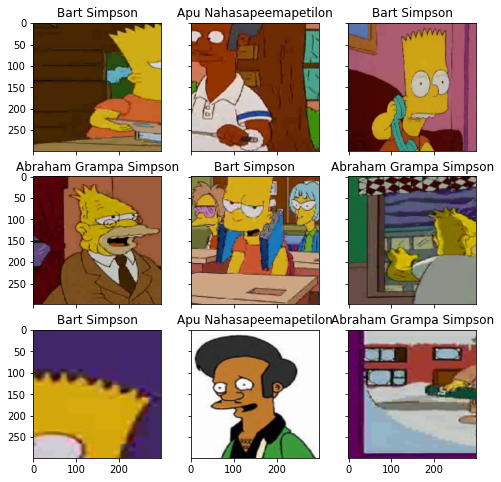

In [101]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Возмем inception_v3 и дообучим его


In [102]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

In [103]:
# Нужно поменять размер картинок на 299, иначе будет ошибка, так как размерность станет отрицательной.
# Это вызвано тем, что нейросеть изначально обучалась на картинках размера 299.


model_extractor = models.inception_v3(pretrained=True)

model_extractor.AuxLogits.fc = nn.Linear(768, 42)

In [112]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

model_extractor.aux_logits = False


In [113]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [114]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [115]:
def train(train_files, val_files, model, epochs, batch_size):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            scheduler.step()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [116]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [117]:
n_classes = len(np.unique(train_val_labels))
model_extractor = model_extractor.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(model_extractor)

we will classify :42
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, ker

Запустим обучение сети.

In [118]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [119]:
history = train(train_dataset, val_dataset, model=model_extractor, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss 0.6166910930829212


epoch:   5%|▌         | 1/20 [06:13<1:58:11, 373.24s/it]


Epoch 001 train_loss: 0.6167     val_loss 0.6141 train_acc 0.8372 val_acc 0.8451
loss 0.5208812730882918


epoch:  10%|█         | 2/20 [12:27<1:52:13, 374.08s/it]


Epoch 002 train_loss: 0.5209     val_loss 0.4926 train_acc 0.8639 val_acc 0.8728
loss 0.47449738772874184


epoch:  15%|█▌        | 3/20 [18:42<1:46:06, 374.48s/it]


Epoch 003 train_loss: 0.4745     val_loss 0.4716 train_acc 0.8760 val_acc 0.8743
loss 0.43504883683907075


epoch:  20%|██        | 4/20 [24:56<1:39:47, 374.25s/it]


Epoch 004 train_loss: 0.4350     val_loss 0.4902 train_acc 0.8862 val_acc 0.8716
loss 0.4109683473673328


epoch:  25%|██▌       | 5/20 [31:10<1:33:32, 374.14s/it]


Epoch 005 train_loss: 0.4110     val_loss 0.4368 train_acc 0.8908 val_acc 0.8901
loss 0.3896815788670705


epoch:  30%|███       | 6/20 [37:26<1:27:24, 374.64s/it]


Epoch 006 train_loss: 0.3897     val_loss 0.4487 train_acc 0.8958 val_acc 0.8829
loss 0.3243147417180621


epoch:  35%|███▌      | 7/20 [43:42<1:21:16, 375.08s/it]


Epoch 007 train_loss: 0.3243     val_loss 0.3669 train_acc 0.9148 val_acc 0.9056
loss 0.3000582906955199


epoch:  40%|████      | 8/20 [49:56<1:14:56, 374.69s/it]


Epoch 008 train_loss: 0.3001     val_loss 0.3406 train_acc 0.9202 val_acc 0.9113
loss 0.2981025584336792


epoch:  45%|████▌     | 9/20 [56:09<1:08:37, 374.34s/it]


Epoch 009 train_loss: 0.2981     val_loss 0.3612 train_acc 0.9225 val_acc 0.9029
loss 0.2879640568787884


epoch:  50%|█████     | 10/20 [1:02:25<1:02:29, 374.93s/it]


Epoch 010 train_loss: 0.2880     val_loss 0.3348 train_acc 0.9251 val_acc 0.9146
loss 0.286673867842583


epoch:  55%|█████▌    | 11/20 [1:08:41<56:14, 374.99s/it]


Epoch 011 train_loss: 0.2867     val_loss 0.3488 train_acc 0.9245 val_acc 0.9136
loss 0.2743621963466258


epoch:  60%|██████    | 12/20 [1:14:55<49:58, 374.81s/it]


Epoch 012 train_loss: 0.2744     val_loss 0.3320 train_acc 0.9273 val_acc 0.9123
loss 0.2830081928026161


epoch:  65%|██████▌   | 13/20 [1:21:10<43:43, 374.79s/it]


Epoch 013 train_loss: 0.2830     val_loss 0.3551 train_acc 0.9248 val_acc 0.9117
loss 0.27640469707047927


epoch:  70%|███████   | 14/20 [1:27:26<37:31, 375.29s/it]


Epoch 014 train_loss: 0.2764     val_loss 0.3339 train_acc 0.9282 val_acc 0.9131
loss 0.25571630904249903


epoch:  75%|███████▌  | 15/20 [1:33:42<31:16, 375.34s/it]


Epoch 015 train_loss: 0.2557     val_loss 0.3398 train_acc 0.9322 val_acc 0.9152
loss 0.25752976324229615


epoch:  80%|████████  | 16/20 [1:39:53<24:56, 374.20s/it]


Epoch 016 train_loss: 0.2575     val_loss 0.3361 train_acc 0.9315 val_acc 0.9142
loss 0.2615314979649356


epoch:  85%|████████▌ | 17/20 [1:46:10<18:45, 375.09s/it]


Epoch 017 train_loss: 0.2615     val_loss 0.3429 train_acc 0.9310 val_acc 0.9113
loss 0.26813581966125205


epoch:  90%|█████████ | 18/20 [1:52:24<12:29, 374.68s/it]


Epoch 018 train_loss: 0.2681     val_loss 0.3160 train_acc 0.9295 val_acc 0.9175
loss 0.2603497910221653


epoch:  95%|█████████▌| 19/20 [1:58:40<06:15, 375.07s/it]


Epoch 019 train_loss: 0.2603     val_loss 0.3332 train_acc 0.9301 val_acc 0.9112
loss 0.25840352145328865


epoch: 100%|██████████| 20/20 [2:04:53<00:00, 374.66s/it]


Epoch 020 train_loss: 0.2584     val_loss 0.3478 train_acc 0.9320 val_acc 0.9100


In [120]:
torch.save(model_extractor.state_dict(), 'Inceptionv3.pth')
model_extractor.load_state_dict(torch.load('Inceptionv3.pth'))

<All keys matched successfully>

Построим кривые обучения

In [121]:
loss, acc, val_loss, val_acc = zip(*history)

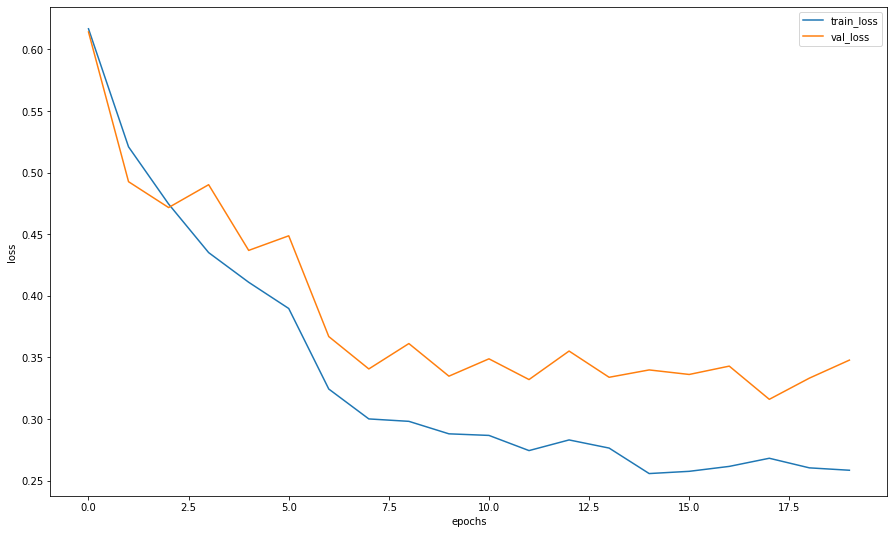

In [122]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

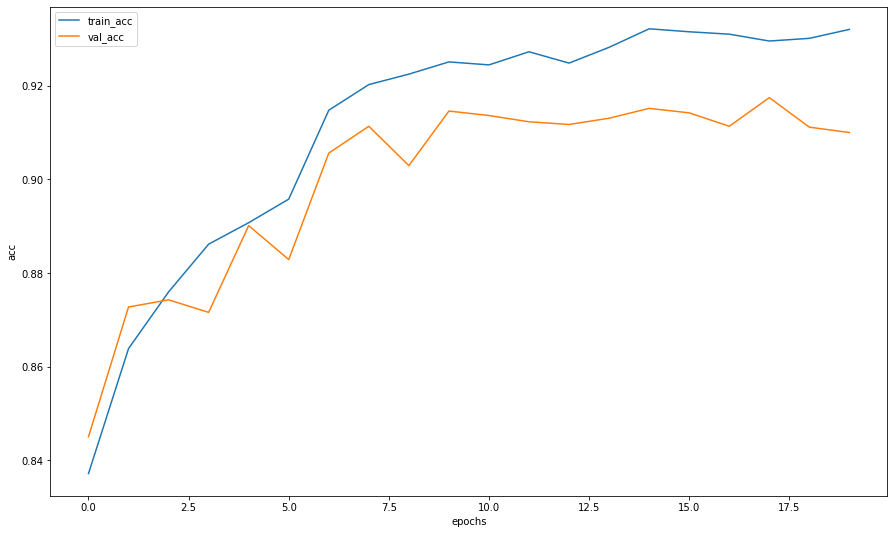

In [123]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot([i.cpu() for i in val_acc], label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [125]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [126]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))

In [127]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

In [128]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [129]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_classed = [label_encoder.classes_[i] for i in actual_labels]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [130]:
actual_classed

['charles_montgomery_burns',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'bart_simpson',
 'abraham_grampa_simpson',
 'barney_gumble',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'agnes_skinner',
 'bart_simpson',
 'charles_montgomery_burns']

In [131]:
from sklearn.metrics import f1_score

f1_score(actual_classed, preds_class, average='macro')


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

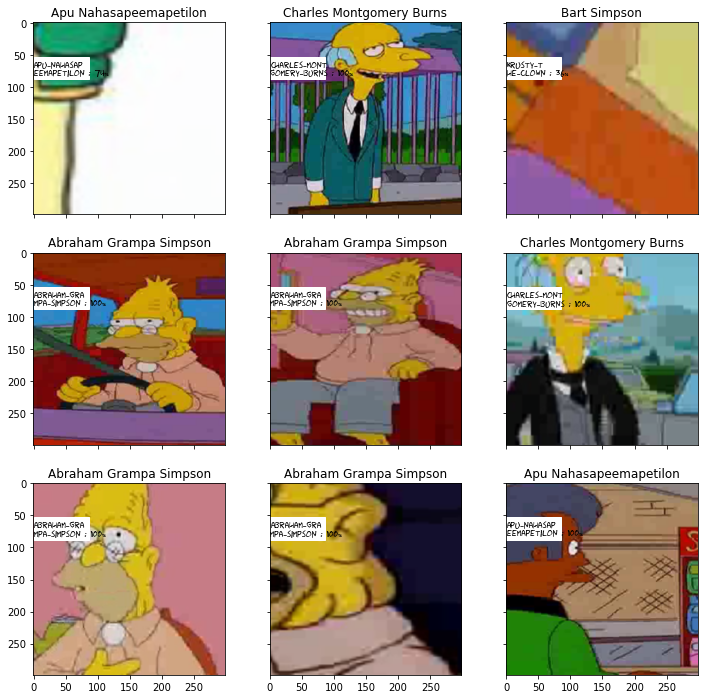

In [132]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_extractor, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [133]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [134]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('simpsons_inception.csv', index=False)
# файл появится у вас на гугл диске

In [135]:
! ls 

characters_illustration.png  label_encoder.pkl	    simpsons_inception.csv
Inceptionv3.pth		     sample_data	    testset
journey-springfield.zip      sample_submission.csv  train


## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
